In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [188]:
tickers = ['AAPL']
daysToUse = []
for ticker in tickers:
  start_date = "2012-12-12"
  end_date = "2022-12-12"
  company_data = yf.download(ticker, start=start_date, end=end_date)

  mses = np.array([])
  # Extract the features (last 5 days of closing prices) and target (current day's closing price)
  features = pd.DataFrame(index=company_data.index)
  lower_end_minus_one = 6
  for j in range(lower_end_minus_one,100):
    for i in range(1, j):
        colname = f"Close-{i}"
        features[colname] = company_data["Close"].shift(i)
    target = company_data["Close"]

    train_features = features.iloc[:-30]
    train_target = target.iloc[:-30]
    test_features = features.iloc[-30:]
    test_target = target.iloc[-30:]
    
    train_features = train_features.dropna()
    train_features.columns = [f"Close-{i}" for i in range(1, j)]
    train_target = train_target.dropna()
    train_target = train_target[j-1:]
    
    model = Ridge(alpha= 1.0, fit_intercept= False, max_iter= 1000, solver= 'svd', tol= 0.001)
    model.fit(train_features.values, train_target)

  # Make predictions for the test set using the recursive approach
    predictions = []
    last_N_days = train_features.tail(j-1)
    for i in range(len(test_target)):
        prediction = model.predict(last_N_days.T)
        predictions.append(prediction[0])
        last_N_days = last_N_days.shift(-1)
        last_N_days.iloc[-1] = prediction

    # Calculate the MSE
    mse  = mean_squared_error(test_target, predictions)
    # Add the MSE to the list of MSEs
    mses = np.append(mses, mse)
    predictions_df = pd.DataFrame(predictions, index=test_target.index, columns=["Predicted"])

print(min(mses), np.argmin(mses)) 
  #Add the index to daysToUse
daysToUse.append(np.argmin(mses))

[*********************100%***********************]  1 of 1 completed
22.4895740921349 12


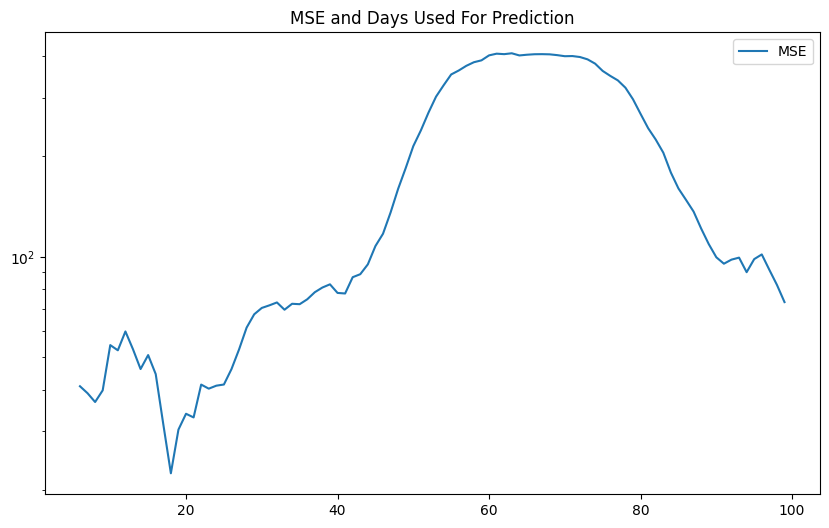

In [189]:
#Plot the MSE in relation to the number of days used
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(lower_end_minus_one,100), y=mses, label='MSE', ax=ax)
plt.yscale("log")
plt.title('MSE and Days Used For Prediction')
plt.show()

In [192]:
#starting with Apple, retrain the model so that it uses the number of 
#days as features which gives the lowest MSE
ticker = "AAPL"
start_date = "2012-12-12"
end_date = "2022-12-12"
apple_data = yf.download(ticker, start=start_date, end=end_date)


# Extract the features (last 85 days of closing prices) and target (current day's closing price)
features = pd.DataFrame(index=apple_data.index)
for i in range(1, lower_end_minus_one+np.argmin(mses)):
  colname = f"Close-{i}"
  features[colname] = apple_data["Close"].shift(i)
target = apple_data["Close"]

# Split the data into training and testing sets
train_features = features.iloc[:-30]
train_target = target.iloc[:-30]
test_features = features.iloc[-30:]
test_target = target.iloc[-30:]

train_features = train_features.dropna()
train_features.columns = [f"Close-{i}" for i in range(1, lower_end_minus_one+np.argmin(mses))]
train_target = train_target.dropna()
train_target = train_target[lower_end_minus_one+np.argmin(mses)-1:]

#Updated Ridge Regression with parameters from GridSearchCV below
model = Ridge(alpha= 1.0, fit_intercept= False, max_iter= 1000, solver= 'lsqr', tol= 0.001)
model.fit(train_features.values, train_target)

# Make predictions for the test set using the recursive approach
predictions = []
last_N_days = train_features.tail(np.argmin(mses)+lower_end_minus_one-1)
for i in range(len(test_target)):
    prediction = model.predict(last_N_days.T)
    predictions.append(prediction[0])
    last_N_days = last_N_days.shift(-1)
    last_N_days.iloc[-1] = prediction


predictions_df = pd.DataFrame(predictions, index=test_target.index, columns=["Predicted"])
# print(predictions_df)
# print(test_target)

[*********************100%***********************]  1 of 1 completed


In [191]:
#Hyper-Parameter Tuning with GridSearchCV
#ran and updated the model above with new parameters

# create a Ridge regression model
model = Ridge()

# lists the parameters to test
params = {
    'fit_intercept': [True, False],
    'alpha': [0.1, 1.0, 10.0],
    'tol': [0.001, 0.0001],
    'max_iter': [1000, 5000],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

# create a GridSearchCV object with 5-fold cross-validation
grid = GridSearchCV(model, params, cv=5)


# fit the GridSearchCV object to the data
grid.fit(train_features.values, train_target)

# print the best hyperparameters and score
print("Best hyperparameters:", grid.best_params_)
print("Score:", grid.score(train_features.values, train_target))

Best hyperparameters: {'alpha': 0.1, 'fit_intercept': False, 'max_iter': 1000, 'solver': 'lsqr', 'tol': 0.0001}
Score: 0.9990021818785889


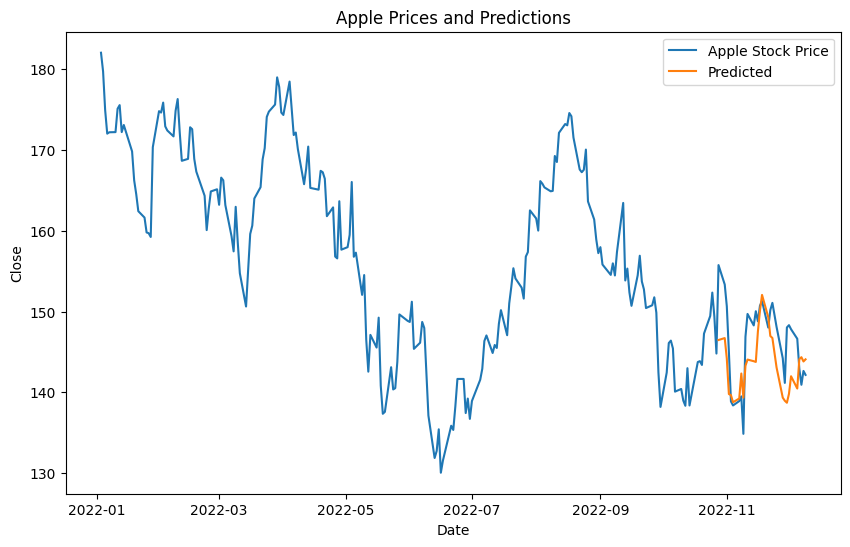

In [193]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=apple_data.loc['2022-01-01':], x=apple_data.loc['2022-01-01':].index, y='Close', label='Apple Stock Price', ax=ax)
sns.lineplot(data = predictions_df, x=predictions_df.index, y='Predicted', label='Predicted', ax=ax)
plt.title('Apple Prices and Predictions')
plt.show()

In [194]:
restOfFAANG = ['AMZN', 'GOOG', 'META', 'NFLX']
for ticker in restOfFAANG:
  start_date = "2012-12-12"
  end_date = "2022-12-12"
  company_data = yf.download(ticker, start=start_date, end=end_date)

  mses = np.array([])
  # Extract the features (last 5 days of closing prices) and target (current day's closing price)
  features = pd.DataFrame(index=company_data.index)
  lower_end_minus_one = 6
  for j in range(lower_end_minus_one,100):
    for i in range(1, j):
        colname = f"Close-{i}"
        features[colname] = company_data["Close"].shift(i)
    target = company_data["Close"]

    train_features = features.iloc[:-30]
    train_target = target.iloc[:-30]
    test_features = features.iloc[-30:]
    test_target = target.iloc[-30:]
    
    train_features = train_features.dropna()
    train_features.columns = [f"Close-{i}" for i in range(1, j)]
    train_target = train_target.dropna()
    train_target = train_target[j-1:]
    
    model = Ridge(alpha= 1.0, fit_intercept= False, max_iter= 1000, solver= 'lsqr', tol= 0.001)
    model.fit(train_features.values, train_target)

  # Make predictions for the test set using the recursive approach
    predictions = []
    last_N_days = train_features.tail(j-1)
    for i in range(len(test_target)):
        prediction = model.predict(last_N_days.T)
        predictions.append(prediction[0])
        last_N_days = last_N_days.shift(-1)
        last_N_days.iloc[-1] = prediction

    # Calculate the MSE
    mse  = mean_squared_error(test_target, predictions)
    # Add the MSE to the list of MSEs
    mses = np.append(mses, mse)
    predictions_df = pd.DataFrame(predictions, index=test_target.index, columns=["Predicted"])
    
  #Print the current lowest MSE for this ticker and the index it occurs at
  print(min(mses), np.argmin(mses)) 
  #Add the index to daysToUse
  daysToUse.append(np.argmin(mses))

[*********************100%***********************]  1 of 1 completed
373.23075147152224 93
[*********************100%***********************]  1 of 1 completed
42.073265034043764 21
[*********************100%***********************]  1 of 1 completed
603.1988150891826 7
[*********************100%***********************]  1 of 1 completed
405.54059682708 0


In [195]:
#redeclare array in case above block has been ran multiple times
#which would give it an array size > 5

# Define the tickers of the stocks to download
tickers = ['AAPL', 'AMZN', 'GOOG', 'META', 'NFLX']
data = yf.download(tickers, start='2012-12-12', end='2022-12-12')['Close']

data_lagged = pd.DataFrame(index=data.index)
for index,ticker in enumerate(tickers):
  for i in range(1, lower_end_minus_one+daysToUse[index]):
    colname = f"{ticker}Close-{i}"
    data_lagged[colname] = data[ticker].shift(i)

#Add {ticker}Close-0 as the last 5 columns 
#This makes it easy to separate training and testing data
#as training will be all the columns that don't have Close-0 in the name
#which is everything before the last 5 columns
for index,ticker in enumerate(tickers):
  colname = f"{ticker}Close-0"
  data_lagged[colname] = data[ticker]
data_lagged = data_lagged.dropna()

[*********************100%***********************]  5 of 5 completed


In [196]:
# Split the data into training and testing sets
# Testing window is much shorter than before as the model 
# 
train_data = data_lagged.iloc[:-30]
test_data = data_lagged.iloc[-30:]

# Fit a linear regression model to the training data for each stock
models = {}
for ticker in tickers:
    X_train = train_data.iloc[:, :-5].values
    y_train = train_data[f'{ticker}Close-0'].values
    model = LinearRegression()
    model.fit(X_train, y_train)
    models[ticker] = model

# Make predictions on the testing data
predFAANG = []
last_N_days = train_data.iloc[-1, :-5]

print(len(last_N_days))
for i in range(len(test_data)):
    X_test_i = np.concatenate([models[ticker].predict(last_N_days.values.flatten().reshape(1, -1)) for ticker in tickers])

    #manually updating the data with new predictions
    #shifting Apple closing prices by 1, deleting Apple Closing Price of 85 days ago
    last_N_days[1:17] = last_N_days[0:16]
    #updating the most recent closing price with the new prediction from the model
    last_N_days[0] = X_test_i[0]

    #shifting data for Amazon
    last_N_days[17:115] = last_N_days[16:114]
    last_N_days[16] = X_test_i[1]

    #shifting data for Google
    last_N_days[115:141] = last_N_days[114:140]
    last_N_days[114] = X_test_i[2]

    #shifting data for Meta
    last_N_days[141:153] = last_N_days[140:152]
    last_N_days[140] = X_test_i[3]

    #shifting data for Netflix
    last_N_days[153:158] = last_N_days[152:157]
    last_N_days[152] = X_test_i[4]


    predFAANG.append(X_test_i)
    
# Create a dataframe with the predicted values
predFAANG_df = pd.DataFrame(predFAANG, columns=tickers, index=test_data.index)


# Calculate the MSE for each company's stock price
mse_values = {}
for ticker in tickers:
    y_test = test_data[f'{ticker}Close-0'].values
    y_pred = predFAANG_df[ticker].values
    mse = mean_squared_error(y_test, y_pred)
    mse_values[ticker] = mse

# Print the MSE values for each company
print(mse_values)

158
{'AAPL': 78.80312929755634, 'AMZN': 2232.170652127225, 'GOOG': 263.36869488116247, 'META': 196.3839943135714, 'NFLX': 32399.054698287924}


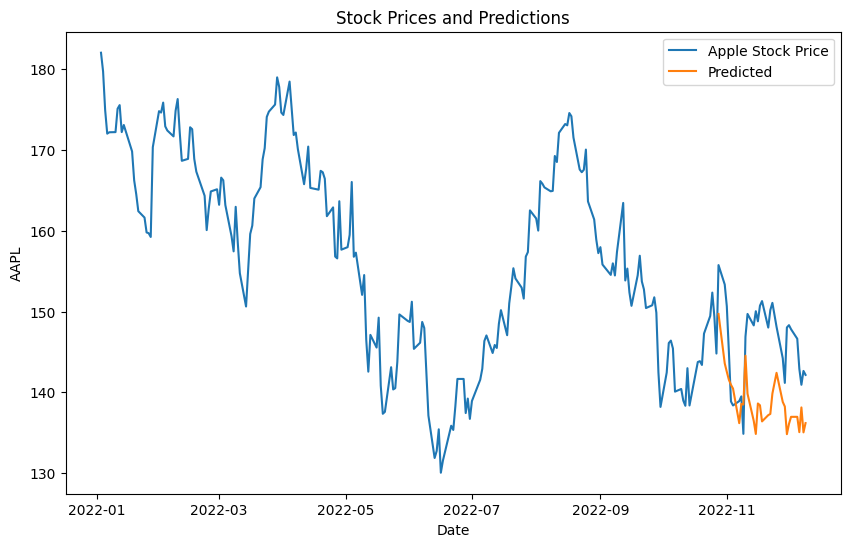

In [197]:
#Predicted Apple Stock Price vs Actual with FAANG prices as features
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data = data['AAPL'].loc['2022-01-01':], label='Apple Stock Price', ax=ax)
sns.lineplot(data = predFAANG_df, x=predFAANG_df.index, y='AAPL', label='Predicted', ax=ax)
plt.title('Stock Prices and Predictions')
plt.show()

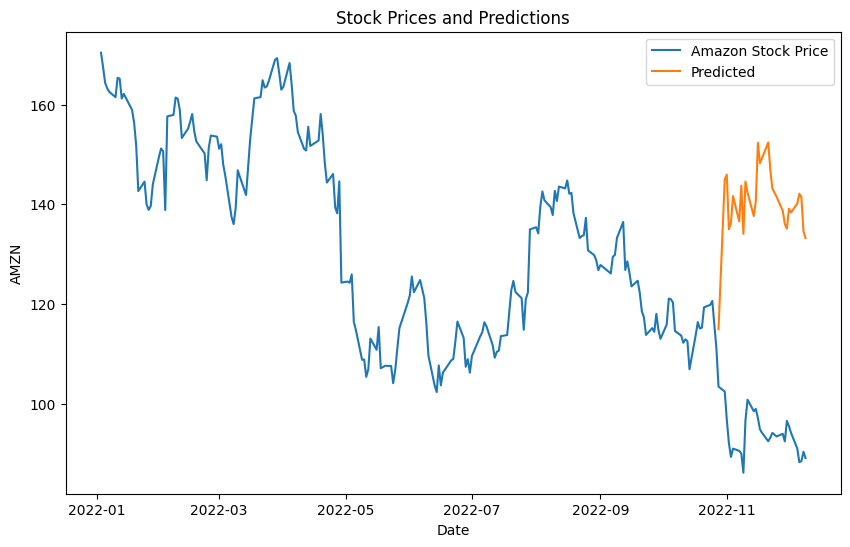

In [198]:
#Predicted Amazon Stock Price vs Actual with FAANG prices as features
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data = data['AMZN'].loc['2022-01-01':], label='Amazon Stock Price', ax=ax)
sns.lineplot(data = predFAANG_df, x=predFAANG_df.index, y='AMZN', label='Predicted', ax=ax)
plt.title('Stock Prices and Predictions')
plt.show()

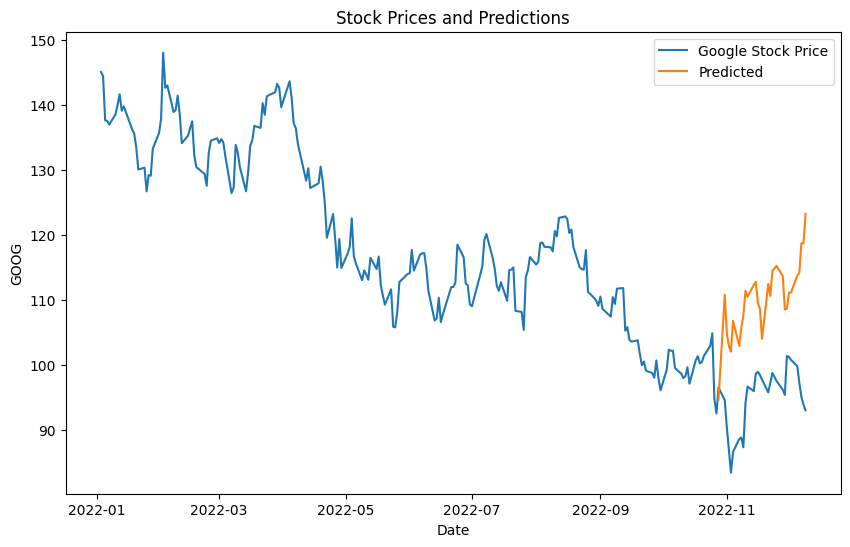

In [199]:
#Predicted Google Stock Price vs Actual with FAANG prices as features
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data = data['GOOG'].loc['2022-01-01':], label='Google Stock Price', ax=ax)
sns.lineplot(data = predFAANG_df, x=predFAANG_df.index, y='GOOG', label='Predicted', ax=ax)
plt.title('Stock Prices and Predictions')
plt.show()

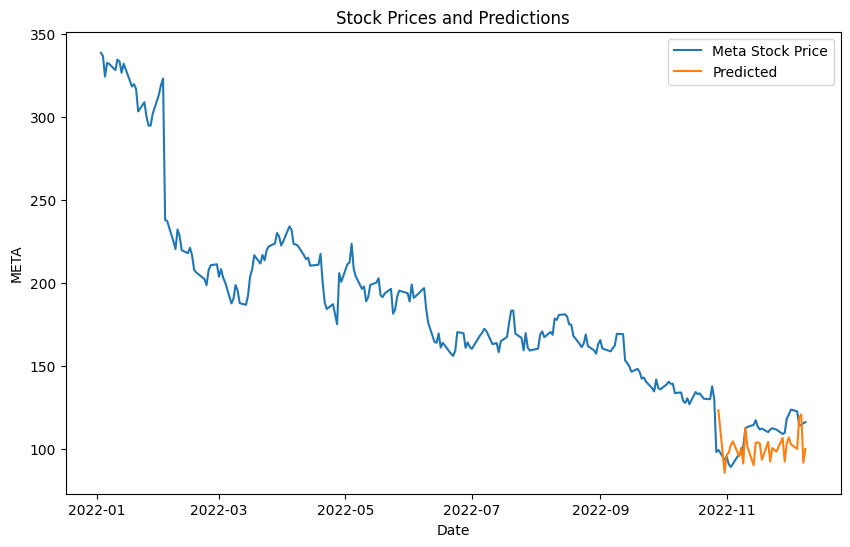

In [200]:
#Predicted META Stock Price vs Actual with FAANG prices as features
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data = data['META'].loc['2022-01-01':], label='Meta Stock Price', ax=ax)
sns.lineplot(data = predFAANG_df, x=predFAANG_df.index, y='META', label='Predicted', ax=ax)
plt.title('Stock Prices and Predictions')
plt.show()

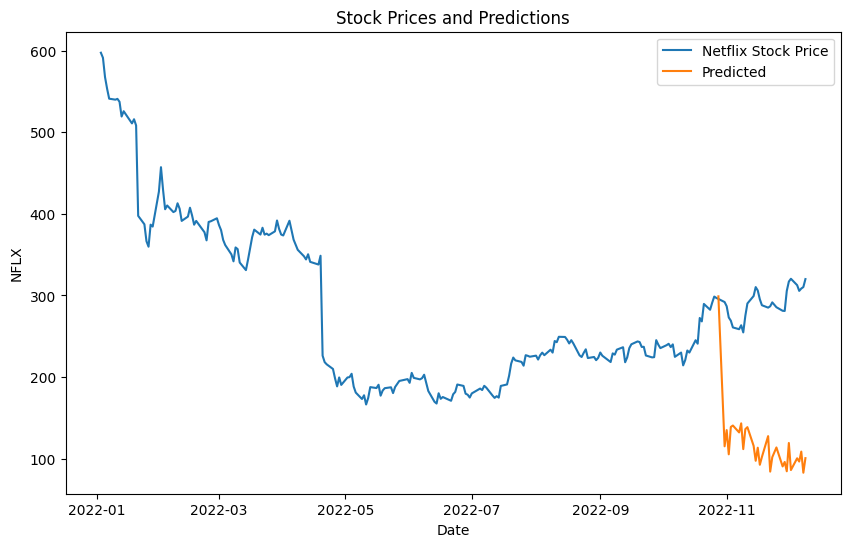

In [201]:
#Predicted Netflix Stock Price vs Actual with FAANG prices as features
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data = data['NFLX'].loc['2022-01-01':], label='Netflix Stock Price', ax=ax)
sns.lineplot(data = predFAANG_df, x=predFAANG_df.index, y='NFLX', label='Predicted', ax=ax)
plt.title('Stock Prices and Predictions')
plt.show()